<a href="https://colab.research.google.com/github/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/3_AI_for_Wildlife_Images/Deep_Learning_for_Camera_Traps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3 - AI for Wildlife Images

## TODO: 
* Fill following "what we will learn cell when done" with content
* Enumerate sections?!
* Given the potential of external visibility let's add a nice readme in the general github page. 


## What we will learn

In this weeks colab we will compare manual annotation of wildlife images to automated annotation through a trained animal detection model. Next, we are going to train a deep learning model for species classification from scratch and investigate the impact of some design choices. Specifically, the learning outcomes break down to:

1. a 
2. b
3. c
4. d
5. e
6. f

In the process you will also learn about:

# Intro

## Computer Vision

**What is Computer Vision?**

Development of automated systems that can extract useful information from images or sequences of images 

**What do computers see?** <br>
* Images are  2-Dimensional numerical matrices representing the pixel intensity. 
* Colored images become 3-D (RGB). 
* Videos are sequences of such images.


<img src="https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/3_AI_for_Wildlife_Images/images/pixels_and_matrices.png?raw=1" alt="drawing" width="400"/>

Most of the computer vision tasks nowadays are tackled with deep neural networks.

**Examples**

* Image Classification: Classifying chest X-Rays of patients as healthy or pneumonia.
* Object Detection: Detecting car signs in traffic cameras for penalty charges.
* Semantic Segmentation: Map pixels of land into water, grassland, roads

<img src="https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/3_AI_for_Wildlife_Images/images/cv_tasks.png?raw=1" alt="drawing" width="800"/>

In this lab, we are going to tackle two tasks of ecological interest using Computer Vision, specifically:
* **Object Detection:** Detecting animals in camera trap photos
* **Image Classification:** Classifying species in camera trap data.

We will try to solve the above tasks using Deep Learning, either by exploiting existing models or training our own. <br><br>
But first let's take a look on what camera trap sensors look like and how this type of data is collected.

## Data Collection

**Camera traps** are static cameras set up in the wild to monitor animal populations. Typically, a shot from a camera trap is triggered by motion taking place in the camera's field of view.

Each camera trap site can represent variables that ecologists want to include in their analysis. For example, the location of a camera can correspond to different gradients of human pressure. Thus, observing the biodiversity across different locations and hence different gradients of anthropogenic pressure can help us quantify the impact and potentially inform future decision making.

<img src="https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/3_AI_for_Wildlife_Images/images/ct.png?raw=1" alt="drawing" width="200"/>

Below you see consecutive frames captured by a camera trap in Kenya. It shows a hyena entering the scene and checking out a buffalo!

<img src="https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/3_AI_for_Wildlife_Images/images/hyena.gif?raw=1" alt="drawing" width="500"/>

(image frames from a camera trap set up in Kenya for the [Biome Health Project](https://www.biomehealthproject.com/))

## The utility of GPUs for Computer Vision
* As you know by know, more data can train better algorithms
* Graphics Processing Units (GPUs) enable parallelization in the way we process data and thus allow for inclusion of more without compromising the time needed to train a model with them 
* Especially useful for image processing



---



# Setup Steps
The following steps are required to set the notebook for the tasks of this lab. Follow the instructions but do not pay attention to the code and potential output messages as they are irrelevant for main content of the lab

## A) Before starting make sure you change the hardware for this notebook to GPU.
* To do this go to *'Runtime'* then *'Change runtime type'* and select GPU as the preferred Hardware accelerator.

## B) Mount your Google Drive and Add a link to the data we will use today

* Mount your Google drive to this Colab by running the following command

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* The camera trap data and some functions we are going to use for the lab are stored in the following public GDrive folder:<br>https://drive.google.com/drive/folders/1HtPoTRl1vT1Dn1SGdc1ps51G8QrY8bbx?usp=sharing

* Open the above link and select the *'Add shortcut to Drive'* option as shown in the image below. This should now be available in your 'drive' folder in the 'Files' tab of Colab and ready to use for species classification.

<img src="https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/3_AI_for_Wildlife_Images/images/add_data_shortcut_to_drive.png?raw=1" alt="drawing" width="400"/>

## C) Install Dependencies

Let's install some dependencies for today's lab.

* First, let's install some tools for image annotation

In [ ]:
%%capture
import os
import pathlib
# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
os.chdir('models/research')

In [ ]:
%%capture
# Install the Object Detection API
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

In [ ]:
os.chdir('../..')

* Next, we install PyTorch, the deep learning library we are going to use for the deep learning experiments. In addition, we are going to setup MegaDetector, the animal detection framework developed by Microsoft AI for Earth.

<img src="https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/3_AI_for_Wildlife_Images/images/pt_and_ai4earth.png?raw=1" alt="drawing" width="400"/><br><br>

* Installing PyTorch (might take around 2 minutes)

In [ ]:
%%capture
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

* Download most recent MegaDetector model and install some of its dependencies.

In [ ]:
%%capture
!wget -O /content/md_v5a.0.0.pt https://github.com/microsoft/CameraTraps/releases/download/v5.0/md_v5a.0.0.pt
!pip install humanfriendly jsonpickle

* Clone the Github repositories needed to run MegaDetector on this machine. These include the latest CameraTraps and essential utilities by Microsoft AI for Earth along with the YOLOv5 repository (YOLO is an established family of object detectors in vision)

In [ ]:
%%capture
!git clone https://github.com/microsoft/CameraTraps 
!git clone https://github.com/microsoft/ai4eutils
!git clone https://github.com/ultralytics/yolov5/
!cd yolov5 && git checkout c23a441c9df7ca9b1f275e8c8719c949269160d1

* Include the git repositories downloaded above to the python path, so that they become easily accessible through code

In [ ]:
import sys
os.environ['PYTHONPATH'] += ":/content/ai4eutils"
os.environ['PYTHONPATH'] += ":/content/CameraTraps"
os.environ['PYTHONPATH'] += ":/content/yolov5"



---



# **Part 1: Detecting Animals in Camera Trap Data**

* After camera traps for a survey are set up, photos start getting captured automatically which means that **huge amounts of data can be accumulated** after some time. Interesting insights can be hiding within large image collections and even though having access to these collection sounds great, it also means that ecologists will need to spend a lot of time to view them, identify and report their underlying content.
* As a matter of fact, **many of the images can be empty** as sensors can be triggered by irrelevant movements in the environment. In addition, it is possible to witness presence of humans or vehicles in the scene i.e. categories that are not necessarily interesting for biodiversity monitoring. 
* On that end, computer vision approaches such as MegaDetector can be exploited to accelerate the labeling process and optimize for the time ecologists spend on the consevation efforts. [link text](https://)



But first, let's try to understand how we would tackle the image labeling problem manually

## Image Labeling

The annotation of images can be intended for a couple of different scenarios:
* Use the acquired information directly for ecological analysis
* Use the images along with the associated labels obtained to train a machine learning model in a *supervised learning* setting

Given the large amounts of camera trap data produced, ecologistics traditionally take a subset of the images, annotate and directly use the obtained information to reason about the underlying ecosystem 

### Labeling Images for Ecological Analysis

* Labeling is a time-consuming process
* Usually compromises are needed, e.g. annotating a subsample of the data
* Plus, the more time a human spends labeling the more likely it is to start making mistakes!

Now Let's try to label 10 images on our own to see how the process is

In [ ]:
# path for detection data
detection_data_path = 'drive/MyDrive/BIOS0032_AI4Environment_Lab3Data/detection_data/'

In [ ]:
# import libraries we'll use
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import time
from object_detection.utils import colab_utils
import pandas as pd
%matplotlib inline
def load_image_into_numpy_array(image_path,output_image_dimensions=None):
  '''
  Given an image path and output dimensions, load and return an image as numpy array
  '''
  if output_image_dimensions:
    img = Image.open(image_path).resize(output_image_dimensions)   
  else:
    img = Image.open(image_path)
  return np.array(img)

Let's load the images to annotate

In [ ]:
# total number of images to annoate
total_images = 10

# define path where the images are and get a list of all the images inside it
image_directory = os.path.join(detection_data_path,'images/') #
list_of_images = os.listdir(image_directory) 

# create a list with the numpy arrays that correspond to each of the images to annotate
list_of_image_arrays = []
for i,image in enumerate(list_of_images[0:total_images]):
  image_path = os.path.join(image_directory,image)
  image_array = load_image_into_numpy_array(image_path,output_image_dimensions=(1000,600))
  list_of_image_arrays.append(image_array)

### **Exercise** 🐘
---
<br>

* The **task is to annotate a set of 10 images**, putting a box around anything you believe is an animal. 
* Try to place the box directly around the animal, i.e. not including anything else 
* Some of these images can be empty, so if you can not see any animal, go to next image. 
* Start the process by running the next 2 cells. When you are done click submit and run the following cell right after to measure your time.


In [ ]:
annotation_starts = time.time()

In [ ]:
# list to store object detection annotations
tagged_image_boxes = []
# lets start annotatin the list of images generated above
colab_utils.annotate(list_of_image_arrays, box_storage_pointer=tagged_image_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# run this cell straight after your annotation
annotation_ends = time.time()

In [ ]:
# convert time to minutes
minutes = (annotation_ends-annotation_starts)//60
seconds = (annotation_ends-annotation_starts)%60
print('The annotation of the {} images lasted {} minutes and {} seconds'.format(total_images,int(minutes),np.round(seconds,1)))

The annotation of the 10 images lasted 3 minutes and 45.8 seconds


In [ ]:
# lets see how the produced animal annotations look like
print(tagged_image_boxes)

[array([[0.60940104, 0.        , 0.98273437, 0.329     ],
       [0.48773437, 0.423     , 0.87773437, 0.654     ],
       [0.43606771, 0.527     , 0.96106771, 0.889     ]]), array([[0.12273438, 0.138     , 0.47440104, 0.296     ],
       [0.12273438, 0.138     , 0.47440104, 0.296     ],
       [0.00273437, 0.452     , 0.66606771, 0.836     ]]), None, None, None, None, array([[0.34773438, 0.325     , 0.48106771, 0.418     ]]), None, None, array([[0.        , 0.003     , 0.66106771, 0.359     ]])]


Each image that contains an animal has one or more boxes that correspond define the position of the 4 edges of the box within the image. The empty images have a None value instead

In [ ]:
# given produced annotation list, we calculate total animals and the number of images with animals
number_of_animal_tags = sum(x.shape[0] for x in tagged_image_boxes if x is not None)
number_images_with_animal_tags = sum(x is not None for x in tagged_image_boxes)
print('In total, you found {} animals across {} images while {} out of the {} images were tagged as empty.'.format(number_of_animal_tags,number_images_with_animal_tags,total_images-number_images_with_animal_tags,total_images))


In total, you found 8 animals across 4 images while 6 out of the 10 images were tagged as empty.


## MegaDetector

* As mentioned above, to detect animals automatically we will utilize **MegaDetector**, a model trained by Microsoft AI for Earth on lots of annotated images captured in a variety of ecosystems. This model is able to **detect animals, people, and vehicles within camera trap images**. 
* An already trained or else  **pretrained** model is essentially corresponding to a model with parameters learnt when training with a dataset different from the one in our task. Here, we use the model pretrained to detect animals to reason about our images.
* MegaDetector detections comes with a confidence threshold between 0 and 1 where 0 corresponds to a completely certain prediction and 1 to a fully certain one.
* For the particular tasks, images with low animal detection confidence are considered **empty**.
* Note: Depending on our task we might want to relax this threhold, i.e. if we do not want to miss a single animal and we can afford viewing false detections we can lower it

### Run MegaDetector on a set of camera trap images collected in Kenya
These include the 10 images you annotated in the task above

In [ ]:
# define confidence threshold for MegaDetector. Images with detections below this confidence will be considered empty
confidence_threshold='0.2' 
# define path where MegaDetector's detections will be saved
output_file_path ='/content/results/md_detections.json'
# name of pretrained model
pretrained_model='md_v5a.0.0.pt'

In [ ]:
# run megadetector with the defined parameters on the images under the image directory
!python /content/CameraTraps/detection/run_detector_batch.py "$pretrained_model" "$image_directory" "$output_file_path" --threshold "$confidence_threshold" --recursive --output_relative_filenames --quiet

50 image files found in the input directory
PyTorch reports 1 available CUDA devices
GPU available: True
Using PyTorch version 1.10.1+cu113
Fusing layers... 
Model summary: 574 layers, 139990096 parameters, 0 gradients
Sending model to GPU
Loaded model in 8.89 seconds
Loaded model in 8.89 seconds
100% 50/50 [00:36<00:00,  1.38it/s]
Finished inference for 50 images in 48.11 seconds
Output file saved at /content/results/md_detections.json
Done!


MegaDetector produced a dictionary with the detection for each image. For the same set of 10 images we calculate again the total animals and the number of images that included at least one

In [ ]:
# given the generated file with megadetector's detection , we calculate total animals and the number of images with animals
with open(output_file_path) as f:
  md_detections = json.load(f)
animals_per_img_MD = []
for md_tagged_img in md_detections['images']:
  if md_tagged_img['file'] in list_of_images[0:10]:
    animals_per_img_MD.append(len(md_tagged_img['detections']))
number_of_animal_tags_MD = np.sum(animals_per_img_MD) 
number_images_with_animal_tags_MD = np.count_nonzero(animals_per_img_MD)
np.sum(np.array(animals_per_img_MD)>0)
print('In total, MegaDetector found {} animals across {} images while {} out of the {} images were tagged as empty.'.format(number_of_animal_tags_MD,number_images_with_animal_tags_MD,total_images-number_images_with_animal_tags_MD,total_images))


In total, MegaDetector found 16 animals across 4 images while 6 out of the 10 images were tagged as empty.


### Visualize detections of MegaDetector
Let's take a visual look on the annotations produced by MegaDetector

In [ ]:
# first we will use the following utility to store detections on top of images in the following directory
visualization_dir='/content/results/visualized_images'
!python /content/CameraTraps/visualization/visualize_detector_output.py "$output_file_path" "$visualization_dir" --confidence "$confidence_threshold" --images_dir "$image_directory"

detection_categories provided
Detector output file contains 50 entries.
Rendering detections above a confidence threshold of 0.2
100% 50/50 [00:07<00:00,  6.89it/s]
Skipped 0 failed images (of 50)
Skipped 0 missing images (of 50)
Rendered detection results on 50 images, saved to /content/results/visualized_images


anno_2018_NB01_001794.JPG


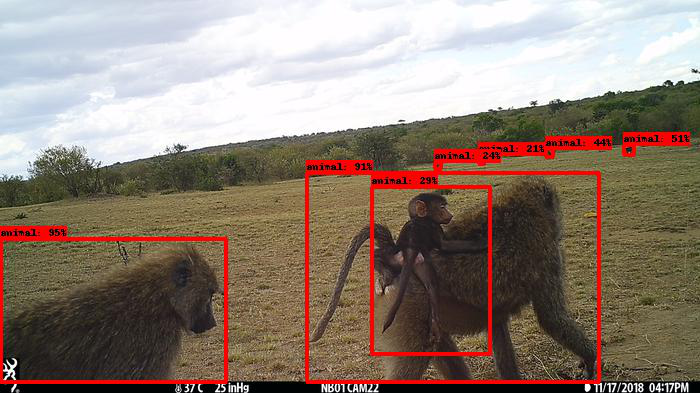

anno_2018_NB03_001071.jpg


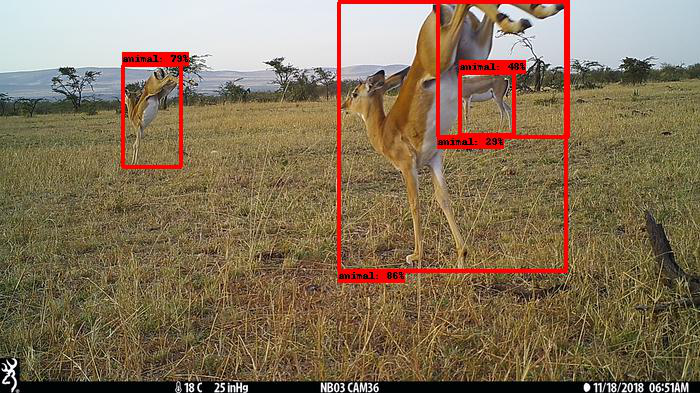

anno_2018_NB42_021230.JPG


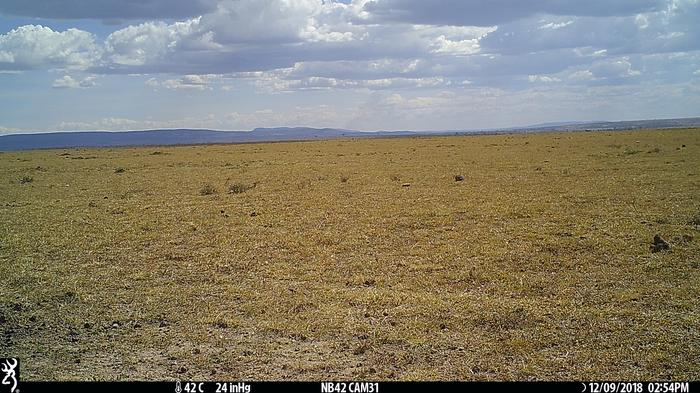

anno_2018_MN15_009733.JPG


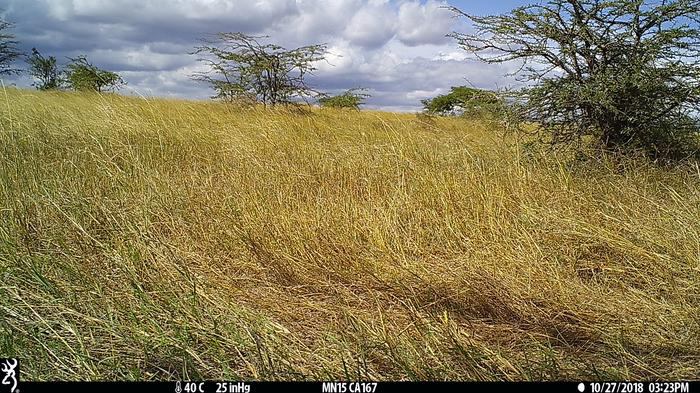

anno_2018_MT40_009674.JPG


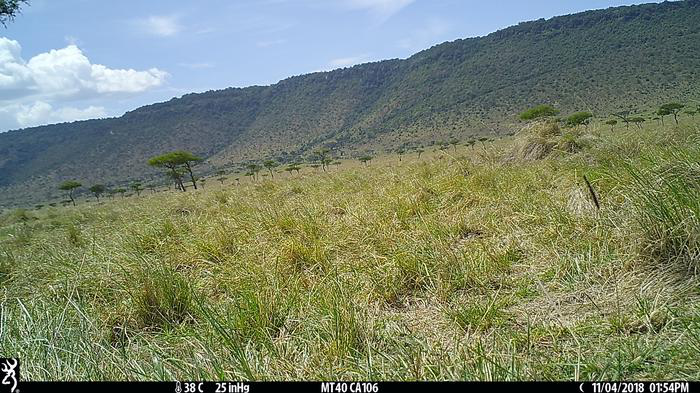

anno_2018_OMC11_009862.JPG


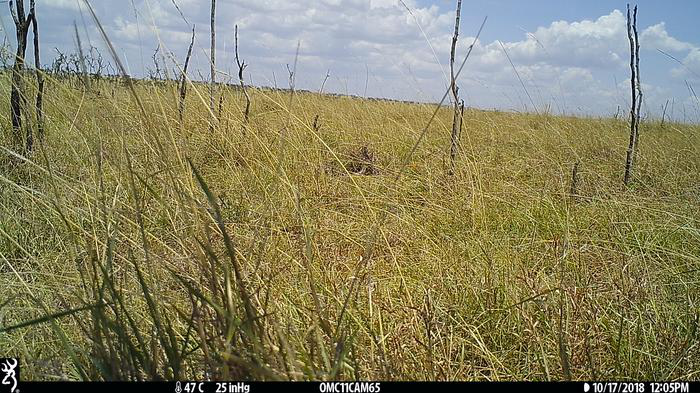

anno_2018_OMC04_001358.JPG


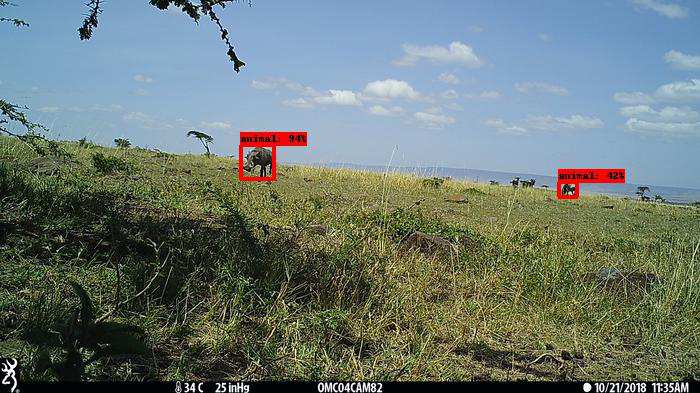

anno_2018_OMC26_004593.JPG


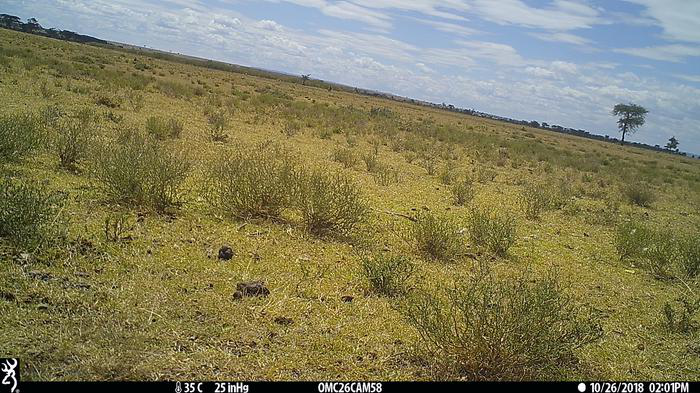

anno_2018_MN48_027239.JPG


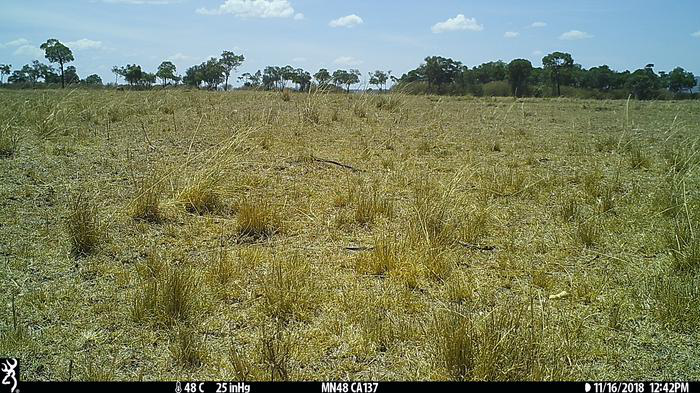

anno_2018_NB26_000679.JPG


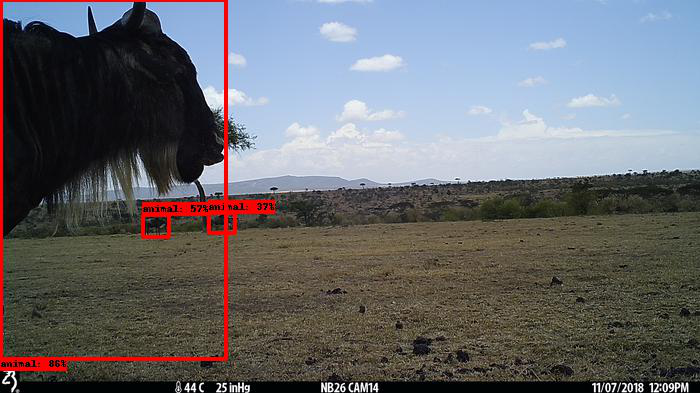

In [ ]:
# show the images with bounding boxes in Colab
for viz_file_name in ['anno_'+img for img in list_of_images[0:10]]: ## viewing tags from images seen before
  print(viz_file_name)
  im = Image.open(os.path.join(visualization_dir, viz_file_name))
  display(im)

**How many animals did you manage to find?!**

### Make detections analysis-ready

* We will now take a look into MegaDetector results across all of the 50 images stored under our image path.
* Below we save the results in a pandas dataframe format to make it easier to manipulate. Run the next cell without drawing focusing too much on the underlying code.

In [ ]:
def transform_md_output(md_detections,category_dict):
  '''
  Given a python dicrionary with the ditections, this function transforms megadetector output into a simple pandas dataframe that is easier to analyse
  '''
  md_df = pd.DataFrame()

  for md_tagged_img in md_detections['images']:
    row = {'image_id':md_tagged_img['file']}
    conservancy = ''.join([char for char in md_tagged_img['file'].split('_')[1] if char.isalpha()])
    row['conservancy'] = conservancy
    if len(md_tagged_img['detections'])>0:
      for det_row in md_tagged_img['detections']:
        row['confidence'] = det_row['conf']
        row['category'] = category_dict[det_row['category']]
        md_df = md_df.append(row,ignore_index=True)
    else:
      row['confidence'] = 0.0
      row['category'] = 'empty'
      md_df = md_df.append(row,ignore_index=True)
  return md_df

## what do output categories of megadetector mean. we define 0 as the empty category, i.e. where there is no detection within an image with more than the treshold defined above
category_dict = {'0':'empty','1': 'animal', '2': 'person', '3': 'vehicle'}
## given detection output of megadetector, get the results in a pandas dataframe
md_df = transform_md_output(md_detections,category_dict)

### **Exercise** 🦌
---
<br>

Using the dataframe with the MegaDetector detections produced above (`md_df`), calculate:

* The percentage of empty images.
* The total number of animals detected with MegaDetector
* The maximum number of animals detected in a single image. Can you visualize this image?
* Number of animals per conservancy
* What are some obvious benefits of using megadetector?
* (Optional) If time allows change the confidence threshold of megadetector and see how the above conclusions change

Note: The rows in the dataframe are more than 50, why do you think that is the case?<br>

Pandas Tip: use the `.groupby()` function to make quick aggregate calculations


To conclude, MegaDetector is a great general model that can be used to identify the camera trap images that include one or more animals and draw a box around them. The above can save a lot of human processing time given that a large percentage of the photos can be empty. However, MegaDetector does not identify animals to the species level, which is not enough for accurate biodiversity monitoring that depends on more detailed information for the data captured. 

For this reason, we can train a model to perform species classification given the animal images. That is going to be the subject of the following task.

---

# **Part 2: Species Classification in the wild**

You are going to tackle the problem of Image Classification on a challenging real-world task. In particular, we will try to recognize species in photos captured from camera traps i.e. static cameras set up in the wild using Deep Learning. The dataset used here is a subset from the Caltech Camera Traps collection (Beery et al., 2018).

In [ ]:
# path for classification data
classification_data_path = 'drive/MyDrive/BIOS0032_AI4Environment_Lab3Data/classification_data/'
# get inside this path
os.chdir(classification_data_path)

In [ ]:
# %reload_ext autoreload
# %autoreload 2

import os
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy

from PIL import Image
import torchvision
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.models as models

# matplotlib.use('TkAgg')
%matplotlib inline

## NOTE: Reload the following libraries when functions and utilities are implemented
from dataset import CTDataset ##needs to be implemented (see below)
from training_utils import train,validate, accuracy #train, validate need to be implemented (see below)

# Task 1: Loading and Preparing Data

In [ ]:
# If you have activated the GPU feature in the Colab device you will get better performance, otherwise a slower CPU will be used
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

### Load annotation and path file
We load a python dictionary that for each of the train, validation and test splits has a list of rows that correspond to the path of the image, the target id and the class name correspond to this target id. <br>
Our training set consists of 12606 images that are distributed (in an imbalanced manner) across 15 species. Some of them are well represented and some not, some appear during day and some during night. In addition the data come from diverse locations and for some of them there is no overlap between the defined training and test sets.<br>

In [ ]:
ls

cct20_labels.json         dataset.py    train/
cct20_labels_large.json   __pycache__/  training_utils.py
cct20_labels_random.json  test/         validation/


In [ ]:
# Dictionary with train,val and test data and every row in format [img_path, class id, class name]
with open('cct20_labels.json') as f:
    cct20_dict = json.load(f) 

In [ ]:
## list all species in training set
all_classes = list(set([row[2] for row in cct20_dict['train']]))
num_classes = len(all_classes) 
print('Total of {} classes in the training set. \nThese are:{}'.format(num_classes,', '.join(all_classes)))

Total of 15 classes in the training set. 
These are:raccoon, rabbit, dog, coyote, badger, fox, rodent, bobcat, deer, bird, cat, opossum, squirrel, car, skunk


#### Parameters
Some parameters for the upcoming tasks. You can play with these later and observe how performance is affected (if computation capabilities allow).

In [ ]:
initial_img_res=32 #initial image resolution (resize and crop might have a different resolution, i.e. if we want the crop to be a subset of the original image for extra variation
final_img_res = 32 #final image resolution
batch_size = 32 #batch_size
num_epochs = 10 #number of training epochs

### Image Augmentations
During deep learning training, image augmentations can be used to provide a variety in the visual appearance of the input data given that the learning stage comprises of multiple epochs/steps. Below we select a set of such augmentations to "enhance" our training set

In [ ]:
## TODO: Comment out the following transformation placeholders and implement a reasonable set of transformations for the task at hand
train_transform = T.Compose([
    T.Resize(size=initial_img_res),
    T.RandomCrop(size=final_img_res),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)]),
    T.RandomGrayscale(),
    T.ToTensor(),
    ])

val_test_transform = T.Compose([
    T.Resize(size=initial_img_res),
    T.CenterCrop(size=final_img_res),
    T.ToTensor(),
    ])



### Define Class to Load the camera trap dataset class
The dataset class and the respective dataloader routine defines how our training, validation and test datasets are initialized and what is returned when we load data every iteration.  
Note: This functionality is implemented by us and you do not need to take any action


The train, val and test splits are predefined. For each split we define the dataset classes given the respective set of annotations and transformations.

In [ ]:
train_set = CTDataset(root_dir='',annotation_dict=cct20_dict['train'],transform=train_transform)
val_set = CTDataset(root_dir='',annotation_dict=cct20_dict['validation'],transform=val_test_transform)
test_set = CTDataset(root_dir='',annotation_dict=cct20_dict['test'],transform=val_test_transform)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

### Show how transformed images look like
We preview what kind of transformations come out of the constructed Dataloaders. Below, we see differently augmented versions (some augmentations are stochastic) for each of the images subsampled from the constructed training set.

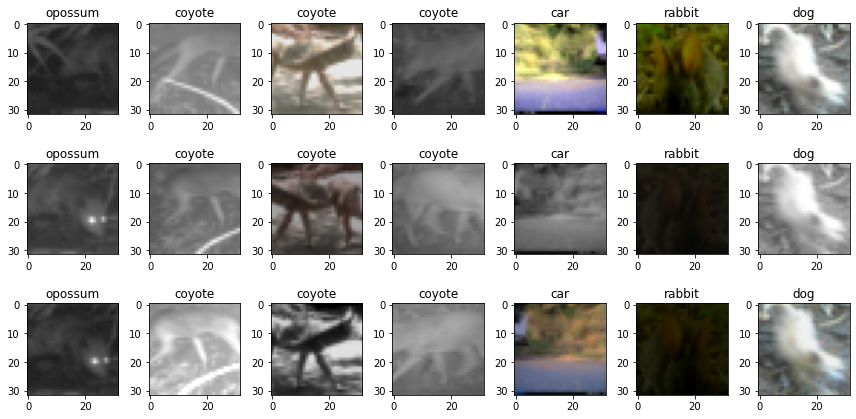

In [ ]:
total_images = 7
total_iter = 3

np.random.seed(42)
random_image_idx =np.random.choice(list(range(0, len(train_set))),total_images)
train_set_subset = torch.utils.data.Subset(train_set, random_image_idx)

random_images = np.random.choice(range(0,batch_size),total_images)
fig,ax = plt.subplots(total_iter,total_images,figsize=(12,6))
for i in range(total_iter):
    train_loader_example = DataLoader(train_set_subset, batch_size=total_images, shuffle=False,drop_last=False)
    loaded_sample = next(iter(train_loader_example))
    for j in range(total_images):
        ax[i,j].imshow(np.array(loaded_sample['img'][j].permute([1,2,0]).cpu()))
        ax[i,j].set_title(loaded_sample['species'][j])
plt.tight_layout()

# Task 2 - Training and Evaluation

The dataloaders defined above load the data for each batch either during the training or the inference stage. The **train** and **validate** functions correspond to the actions taken during a step/epoch of the training or validation phase respectively. The main difference is that during the training phase optimization takes place and the gradients are updated based on the defined loss function.

#### Training a model from Scratch
We are going to use one of the convolutional neural network architectures already implemented in torchvision and train it from scratch on species recognition on Caltech Camera Traps (CCT20). If you wanna learn more about the network architectures follow the torchvision documentation or read the respective paper that suggested it.

In [ ]:
## set a constant instead of random seed for repeatability
torch.manual_seed(42)

In [ ]:
## Loading a model implemented in PyTorch 
## ResNet18 is picked arbitrarily here, we can select other architectures supported.
model = models.resnet18()
## Input Features before final layer of the model
num_ftrs = model.fc.in_features
## Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).Output size equals the number of classes.  There are 15 classes in CCT20
model.fc = torch.nn.Linear(num_ftrs, num_classes)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
## Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Training model from scratch... As the final model we keep the one that achieved the highest validation accuracy during training. <br>

In [ ]:
best_val_acc = 0
best_model_wts = copy.deepcopy(model.state_dict())
train_acc_list = []
val_acc_list = []
# main train loop
for epoch in range(0, num_epochs):
    print("Train epoch {} ... \n".format(epoch))
    train_loss,train_acc = train(train_loader, model, criterion,optimizer, device)  
    val_loss, val_acc,_ = validate(val_loader,model,criterion,device,split='val')
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    if val_acc>best_val_acc:
        print('New best validation accuracy on epoch {} \n \n'.format(epoch))
        best_val_acc = val_acc
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        
print(f'Best validation Accuracy: {best_val_acc:4f} achieved on epoch {best_epoch}')

Train epoch 0 ... 



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



#### Training Accuracy vs Validation Accuracy across the epochs of training (Plot)
We plot the progress of the training and the validation accuracy given predictions by the model during its training stages. Are we overfitting? 

In [ ]:
plt.title('Training vs Validation Accuracy during training')
plt.plot(train_acc_list,color='blue',  label = 'Training Set')
plt.plot(val_acc_list,color='orange',  label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Top-1 Accuracy (%)')
plt.legend()
plt.show()

#### Apply best model on the unseen test set

In [ ]:
# load best model weights
model.load_state_dict(best_model_wts)

In [ ]:
## Evaluate on unseen test set
_, test_acc,preds = validate(test_loader,model,criterion,device,split='test')

#### Accuracy per Species (Plot)
In situations with class imbalance it's **important** to evaluate accuracy across labels or calculate metrics that are robust against imbalance. This evaluation takes place on predictions coming from the test set.

In [ ]:
## given returned list of predictions and ground truth we calculate and plot accuracy per target
correct_per_target = (np.array(test_set.targets) == np.array(preds))
correct_per_species = {}
if len(correct_per_target)>0: # to not break when we run the functions with placeholders (before tasks are done)
    for i,species in enumerate(test_set.species):
        if species not in correct_per_species:
            correct_per_species[species] = []
        correct_per_species[species].append(correct_per_target[i])
    species_ordered = sorted(correct_per_species.keys())
    acc_per_species = []
    for species in species_ordered:
        acc_per_species.append(np.mean(correct_per_species[species])*100)

    plt.title('Accuracy across Camera Trap Species')
    plt.bar(species_ordered,acc_per_species)
    plt.xlabel('Species')
    plt.xticks(rotation = 90)
    plt.ylabel('Top-1 Accuracy')
    plt.ylim(0,100)
    plt.show()
    ## NOTE: badger and deer are very underrepresented

#### TODO: Add Confusion Matrices

#### Transfer Learning
Now let's use the same architecture used above (i.e. ResNet18) but instead start from a pretrained version (ImageNet weights) instead of training from scratch.Transfer-learning from models pretrained on larger datasets is quite common practice in computer vision, i.e. models can be pretrained on ImageNet which instead totals around 1 million images that cover 1000 different classes.

All you need to do go above and replace `models.resnet18()` with ` models.resnet18(pretrained=True)`

## TODO: Following code is the same but with pretrained=True . I can omit and have as a task to retun the above part with new setting

In [ ]:
## Loading a model implemented in PyTorch PRETRAINED on ImageNet 
## ResNet18 is picked arbitrarily here, we can select other architectures supported.
model = models.resnet18(pretrained=True)
## Input Features before final layer of the model
num_ftrs = model.fc.iqn_features
## Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).Output size equals the number of classes.  There are 15 classes in CCT20.
model.fc = torch.nn.Linear(num_ftrs, num_classes)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
## Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Finetuning model on top of weights learnt from ImageNet. As the final model we keep the one that achieved the highest validation accuracy during training.<br>

In [ ]:
best_val_acc = 0
best_model_wts = copy.deepcopy(model.state_dict())
train_acc_list = []
val_acc_list = []


# main train loop
for epoch in range(0, num_epochs):  
    print("Train epoch {} ... \n".format(epoch))
  
    train_loss,train_acc = train(train_loader, model, criterion,optimizer,device)  
    val_loss, val_acc,_ = validate(val_loader,model,criterion,device,split='val')
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    if val_acc>best_val_acc:
        print('New best validation accuracy on epoch {} \n \n'.format(epoch))
        best_val_acc = val_acc
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        
print(f'Best validation Accuracy: {best_val_acc:4f} achieved on epoch {best_epoch}')

#### Training Accuracy vs Validation Accuracy across the epochs of training (Plot)
We plot the progress of the training and the validation accuracy given predictions by the model during its training stages. Are we overfitting? 

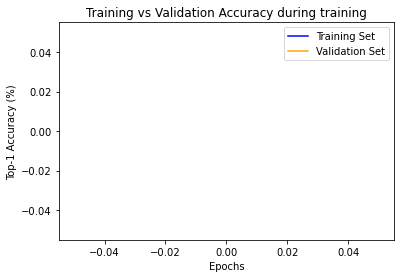

In [ ]:
plt.title('Training vs Validation Accuracy during training')
plt.plot(train_acc_list,color='blue',  label = 'Training Set')
plt.plot(val_acc_list,color='orange',  label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Top-1 Accuracy (%)')
plt.legend()
plt.show()

#### Apply best model on the unseen test set

In [ ]:
# load best model weights
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [ ]:
## Evaluate on unseen test set
_, test_acc,preds = validate(test_loader,model,criterion,device,split='test')

Test prec@1 nan
Test loss nan



#### Accuracy per Speciesc (Plot)
In situations with class imbalance it's **important** to evaluate accuracy across labels or calculate metrics that are robust against imbalance. This evaluation takes place on predictions coming from the test set.

In [ ]:
## given returned list of predictions and ground truth we calculate and plot accuracy per target
correct_per_target = (np.array(test_set.targets) == np.array(preds))
correct_per_species = {}
if len(correct_per_target)>0: # to not break when we run the functions with placeholders (before tasks are done)
    for i,species in enumerate(test_set.species):
        if species not in correct_per_species:
            correct_per_species[species] = []
        correct_per_species[species].append(correct_per_target[i])
    species_ordered = sorted(correct_per_species.keys())
    acc_per_species = []
    for species in species_ordered:
        acc_per_species.append(np.mean(correct_per_species[species])*100)

    plt.title('Accuracy across Camera Trap Species')
    plt.bar(species_ordered,acc_per_species)
    plt.xlabel('Species')
    plt.xticks(rotation = 90)
    plt.ylabel('Top-1 Accuracy (%)')
    plt.ylim(0,100)
    plt.show()
    ## NOTE: badger and deer are very underrepresented

## **Exercise** 🦍

### Task 2B: Larger training size

Now let's use a larger portion of data in our training set.
* Replace *cct20_labels.json* with *cct20_labels_large.json*
* Re-run the above chunk of code. You can run either training from random initialization OR transfer learning for simplicity
* What are your findings on the results after increasing the training data?


### Task 2C: Alternative splits where data are split differently

Similarly to above, we replace dataset with an alternative version. Here we use the same images as in *cct20_labels.json* but the train/validation/test splits are selected randomly. 
* Replace *cct20_labels.json* with *cct20_labels_random.json*
* Re-run the above chunk of code. You can run either training from random initialization OR transfer learning for simplicity
* What are your findings on the results after training with random? What's the relationship between the training and the validation/test loss now?

## Additional Tasks (Optional)
* You can **run for more epochs** to actually reach a point where the model converges. It just takes a lot of time for this lab session
* Experiment **by changing the utilized loss function or the gradient optimizer and** its parameters. 
* Select **different augmentations or the training images to be loaded**. 
* Select final model based on a different criterion. I.e. model that came out from last training step instead of one corresponding to the validation accuracy.
* **Increase image size** from 32 by 32. Actually that is quite small. Classes with fine-grained differences might suffer from low resolution. A resolution around 128 would make more sense but hard to process without a GPU.
* **Use larger model**. Likewise, it's fair to assume that using a better backbone, e.g. by replacing the pre-implemented ResNet18 with a ResNet50 which has double the size of parameters will lead to better performance. Again, to use a larger backbone model you'll probably need a large machine

### Feel free to explore the rich documentation of PyTorch and learn more about this deep learning library
You may find practical info for tools such as the ones used on this lab under the [PyTorch](https://pytorch.org/docs/stable/index.html) or [Torchvision](https://pytorch.org/vision/stable/) documentations.
<br><br>
### Also, here is a nice computer vision tutorial if you want to dig more into computer vision with PyTorch
[Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

# TODO: Add functions in utilities script and load from GDrive
# TODO: Use %%capture test in the beginning of each cell to hide its output

## Appendix

In [ ]:
## Apply MegaDetecor on a sample image (get rid of this)
# img_path = "data/detection/images/2018_MT41_020257.jpg"
# img = Image.open(img_path)
#!python /content/CameraTraps/detection/run_detector.py "md_v5a.0.0.pt" --image_file "/content/data/detection/images/2018_MT41_020257.jpg" --threshold 0.5